# Ranking metrics present in *benchscofi*

We test different accuracy and ranking metrics, and the impact of random (*versus* weakly correlated) splitting into training and testing datasets, across datasets (*e*.*g*., using the real-life dataset ``TRANSCRIPT``).

--------------------------------------------------------
### Table of contents

- [1. Parameters](#1.-Parameters)
- [2. Example of pipeline for training a single model on a single dataset](#2.-Example-of-pipeline-for-training-a-single-model-on-a-single-dataset)
- [3. Ranking metrics](#3.-Ranking-metrics)
    + [3.1 DCG / NCDG](#3.1-DCG-/-NCDG)
    + [3.2 Mean reciprocal rank (MRR)](#3.2-Mean-reciprocal-rank-(MRR))
    + [3.3 R Precision](#3.3-R-Precision)
    + [3.4 Precision @ k](#3.4-Precision-@-k)
    + [3.5 Average Precision (AP)](#3.5-Average-Precision-(AP))
    + [3.6 Mean Average Precision (mAP)](#3.6-Mean-Average-Precision-(mAP))
    + [3.7 Label ranking average precision (LRAP)](#3.7-Label-ranking-average-precision-(LRAP))
    + [3.8 Kendall's $\tau$](#3.8-Kendall's-$\tau$)
    + [3.9 Spearman's $r$](#3.9-Spearman's-$r$)
    + [3.10 Expected reciprocal rank (ERR)](#3.10-Expected-reciprocal-rank-(ERR))
- [4. Test with libmf](#4.-Test-with-libmf)
    + [4.1 Create inputs](#4.1-Create-inputs)
    + [4.2 One class matrix factorization (OCMF)](#4.2-One-class-matrix-factorization-(OCMF))
        - [4.2.a Using a stochastic gradient method](#4.2.a-Using-a-stochastic-gradient-method)
--------------------------------------------------------

In [1]:
from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset
from stanscofi.training_testing import weakly_correlated_split, random_simple_split, cv_training
from stanscofi.validation import compute_metrics, plot_metrics, metrics_list
import stanscofi.validation

from glob import glob
from time import time
import numpy as np
import pandas as pd

import sys #
sys.path.insert(0,"../src/") #
import benchscofi

dataset_folder="../datasets/"
! mkdir -p "../datasets/"
! pip install -q stanscofi==2.0.0
! pip freeze | grep "stanscofi"

/home/kali/miniconda3/envs/benchscofi/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-11 07:56:44.767472: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
stanscofi==2.0.0


## 1. Parameters

In [2]:
random_state = 1234
decision_threshold=0

########################
## Dataset parameters ##
########################
dataset_names = ["TRANSCRIPT"]
split_params = {"metric": "cosine", "test_size": 0.2, "split_randomly": True}

##########################
## Algorithm parameters ##
##########################
algo_params = {
    "PMF": {
        'reg': 0.01,
        'learning_rate': 0.5,
        'n_iters': 160,
        'n_factors': 15,
        'batch_size': 100,
    },
}

## 2. Example of pipeline for training a single model on a single dataset

----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 180 drugs and 101 diseases involved in at least one positive/negative rating
321 positive, 9 negative, 92233 unlabeled (including 18513 unavailable) drug-disease ratings
Sparsity: 0.36 percent (on drugs/diseases with at least one known rating 1.82)
-----------------------------------
* Feature matrices:
#Drug features: 12096	Total #Drugs: 613
Missing features: 0.00 percent
#Disease features: 12096	Total #Disease: 151
Missing features: 0.00 percent
----------------------------------------------------------------------

----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 63 drugs and 58 diseases involved in at least one positive/negative rating
80 positive, 2 negative, 92481 unlabeled (including 74050 unavailable) drug-disease ratings
Sparsity: 0.09 percent (on drugs/diseases with at least one kno

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
2023-08-11 07:56:58.863846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-08-11 07:56:58.868639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-08-11 07:56:58.886723: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-08-11 07:56:58.962653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
BPR: 100%|██████████| 160/160 [00:00<00:00, 1116.40it/s]

<validation.compute_metrics> Computed on #users=151, 67 ignored (44 perc)
<validation.compute_metrics> Computed on #users=151, 106 ignored (70 perc)
Crossvalidation step #1/5 (train AUC 0.752649, test AUC 0.608728)


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished


* Scores
613 unique items, 151 unique users
Scores: Min: -13.696139	Mean: 0.003143	Median: 0.012723	Max: 15.087838	Std: 2.696024

* Classification
613 unique items, 151 unique users
Positive class: 9298, Negative class: 9215

<validation.compute_metrics> Computed on #users=151, 94 ignored (62 perc)


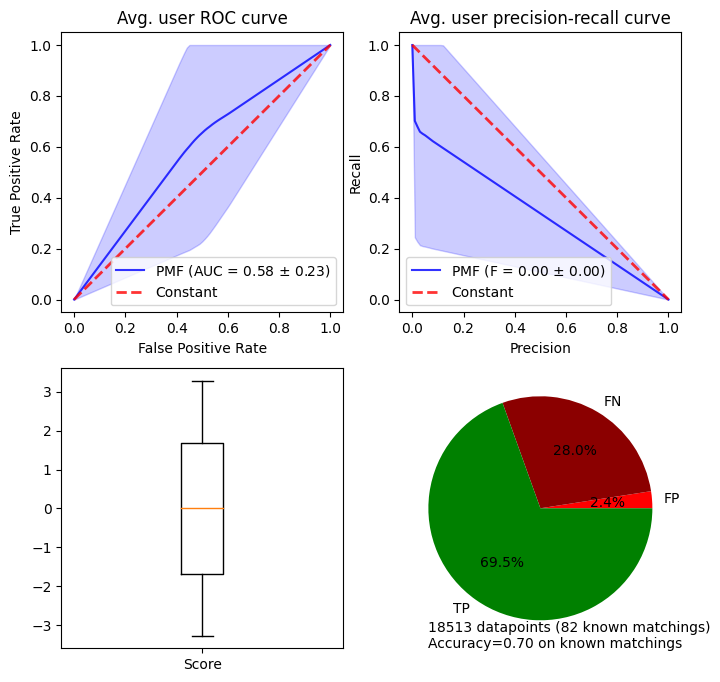

,Value,Average,StandardDeviation
AUC,0.704159,0.582821,0.225721
Rscore,0.029750,0.039749,0.090071
MRR,0.083333,0.054633,0.087174
RP,0.000866,0.031445,0.029384
PrecisionK,0.000000,0.017544,0.056577
RecallK,0.000000,0.035673,0.120567
F1K,0.000000,0.022932,0.074624
AP,0.018041,0.042079,0.050244
MAP,0.018041,0.042079,0.050244
DCGk,0.000000,0.051280,0.177933


In [3]:
def training_testing(dataset_name, split_params, algo, params, random_state, decision_threshold, k, beta):
    #############
    ## Dataset ##
    #############
    dataset_di = load_dataset(dataset_name, dataset_folder)
    dataset_di.setdefault("same_item_user_features", dataset_name=="TRANSCRIPT")
    dataset_di.setdefault("name", dataset_name)
    dataset = Dataset(**dataset_di)

    ############################
    ## Weakly correlated sets ##
    if (not split_params["split_randomly"]):
        (train_folds, test_folds), _ = weakly_correlated_split(dataset, split_params["test_size"], early_stop=1, 
                                                            metric=split_params["metric"], verbose=True)
    ######################
    ## Random splitting ##
    else:
        (train_folds, test_folds), _ = random_simple_split(dataset, split_params["test_size"], 
                                                               metric=split_params["metric"])

    train_dataset = dataset.subset(train_folds, subset_name="Train_"+dataset_name)
    test_dataset = dataset.subset(test_folds, subset_name="Test_"+dataset_name)

    train_dataset.summary()
    test_dataset.summary()

    ###############
    ## Algorithm ##
    ###############
    __import__("benchscofi."+algo)
    model = eval("benchscofi."+algo+"."+algo)(algo_params[algo])

    ###############
    ## Training  ##
    ###############
    #model.fit(train_dataset, random_state)
    ######################
    ## Cross-validation ##
    results = cv_training(eval("benchscofi."+algo+"."+algo), params, train_dataset, 
        threshold=decision_threshold, metric="AUC", k=k, beta=beta, njobs=4, 
        nsplits=5, random_state=random_state, show_plots=False, verbose=True,
        cv_type="random" if (split_params["split_randomly"]) else "weakly_correlated")
    model = results["models"][np.argmax(results["test_metric"])]

    #################
    ## Predictions ##
    #################
    scores = model.predict_proba(test_dataset)
    predictions = model.predict(scores, threshold=decision_threshold)

    model.print_scores(scores)
    model.print_classification(predictions)

    #################
    ## Validation  ##
    #################

    ## disease-wise metrics
    metrics, plot_args = compute_metrics(scores, predictions, test_dataset, metrics=metrics_list,
                                         k=k,beta=beta,verbose=1)
    plot_args.update({"model_name": "PMF", "figsize": (8,8)})
    plot_metrics(**plot_args)

    ## dataset-wide metrics
    y_test = (test_dataset.folds.toarray()*test_dataset.ratings.toarray()).ravel()
    y_test[y_test<1] = 0

    whole_metrics = [
            eval("stanscofi.validation."+metric)(y_test, scores.toarray().ravel(), 5, 1)
            for metric in metrics_list if (metric not in ["Fscore", "TAU"])
    ]

    results = pd.concat(
    (pd.DataFrame([whole_metrics], index=["Value"], columns=[m for m in metrics_list if (m not in ["Fscore","TAU"])]).T,
     metrics), axis=1
    )
    
    return results

## Call
training_testing(
    dataset_names[0], 
    split_params, 
    [a for a in algo_params][0], 
    algo_params[[a for a in algo_params][0]], 
    random_state, 
    decision_threshold, 
    5, 1
)

## 3. Ranking metrics

### 3.1 DCG / NCDG

Formula for normalized discounted cumulative gain (NDCG) up to rank $k<N=$\#pairs on the ranking on pairs by *decreasing* predicted score given by the permutation $\sigma : \{p_1,p_2,\dots,p_k,p_{k+1},\dots,p_N\} \rightarrow [N]=\{1,2,\dots,N\}$, and the list of true scores $t : \{p_1,p_2,\dots,p_k\} \rightarrow \mathbb{R}$ corresponding to the ideal permutation $\sigma^\star$ (such that $(\sigma^\star)^{-1}(1) = \arg\max_{i}t(p_i)$, $\dots$, $(\sigma^\star)^{-1}(N)=\arg\min_{i}t(p_i)$):

$$ \text{nDCG}_k(\sigma,t) := \underbrace{\sum_{i=1}^k \frac{t[\sigma^{-1}(i)]}{\log_2(i+1)}}_\text{DCG$_k(\sigma,t)$} / \underbrace{\sum_{j=1}^k \frac{t[(\sigma^\star)^{-1}(j)]}{\log_2(j+1)}}_\text{ideal DCG$_k(\sigma,t)$=DCG$_k(\sigma^\star,t)$}\;.$$

**Notation:** Let us consider the ranking on $N$ pairs by *decreasing* predicted score identified by $\{1,2,\dots,N\}$ given by permutation $\sigma : \{p_1,p_2,\dots,p_k,p_{k+1},\dots,p_N\} \rightarrow [N]=\{1,2,\dots,N\}$, and the list of true scores $t : \{p_1,p_2,\dots,p_k\} \rightarrow \mathbb{R}$. $N_\text{pos}$ is the number of positive pairs among the $N$ ones.

### 3.2 Mean reciprocal rank (MRR)

Here, we only perform one ''query'' (retrieve a positive pair) and as such, the corresponding rank of the correct answer in our case is the minimum rank of a positive pair in the ranking by predicted scores:

$$ \text{MRR}(\sigma,t) := \arg\min_{\substack{r \in [N]\\t[\sigma^{-1}(r)]=1}} 1/r\;.$$

### 3.3 R-Precision

$$ \text{RP}(\sigma,t) := \frac{\sum_{r=1}^{N_\text{pos}} \delta(t[\sigma^{-1}(r)]=1)}{N_\text{pos}}\;.$$

### 3.4 Precision @ k

$$ \text{Prec@}k(\sigma,t) := \frac{\sum_{r=1}^{k} \delta(t[\sigma^{-1}(r)]=1)}{k}\;.$$

### 3.5 Average Precision (AP)

$$ \text{AP}(\sigma,t) := \frac{1}{N_\text{pos}}\sum_{r=1}^{N_\text{pos}}\text{Prec@}r(\sigma,t)\;.$$

### 3.6 Mean Average Precision (mAP)

Since we only have one class, in our case mAP=AP.

### 3.7 Label ranking average precision (LRAP)

**Notation:** Let us consider $N$ pairs, and the ground truth for pair $i \leq N$ $y_i \in \{0,1\}^2$ ($\|y_i\|_0=1$) and the corresponding predicted score $\hat{y}_i \in [0,1]^2$ ($\|\hat{y}_i\|_1=1$), since, in our case, there is only one single class.

$$\text{LRAP}(p,t) := \frac{1}{N}\sum_{i=1}^N \frac{1}{1+\delta(\hat{y}_i[0]\geq \hat{y}_i[1])}\;.$$

### 3.8 Kendall's $\tau$

If $N_\text{dis}$ is the number of discordant pairs between predicted scores $p$ and true labels $t$ (i.e., $(i,j)$ such that $p[i]<p[j] \land t[i]>t[j]$ or $p[j]<p[i] \land t[j]>t[i]$)

$$\tau(p,t) = 1 - \frac{2N_\text{dis}(p,t)}{C^n_2}\;.$$

A smarter version is implemented in ``scipy`` which takes into account ties.

### 3.9 Spearman's $r$

Roughly Pearson correlation on ranks instead of scores.

### 3.10 Expected reciprocal rank (ERR)

Here, we consider a single query (find one positive pair). If $\sigma$ is the ranking induced by decreasing predicted scores and $t$ the true binary labels on $N$ pairs. This is supposed to introduce some dependency with prior elements encountered in the ranking [[ref]](https://dl.acm.org/doi/abs/10.1145/1645953.1646033)

$$\text{ERR} := \sum_{k=1}^N \frac{1}{k}t[\sigma^{-1}(k)]\Pi_{i=1}^{k-1}(1-t[\sigma^{-1}(i)])\;.$$